First we need a way to load the records into the graph.

Constraints:
- We need to remember where each record came from; there may be multiple datasets loaded into the same graph
- We need to remember which record in the dataset was loaded. Some datasets have multiple records with the same IDs

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def create_graph(datasets, fields):
    # Create the graph
    g = nx.MultiGraph()

    # Add the four fundamental node types as nodes
    g.add_nodes_from(["datasource", "index", "value", "field"])

    # Add the fields and connect them to the "field" nodetype node with an "is_a" relationship
    field_tuples = [(fieldname, "field", {"label": "is_a"}) for fieldname in fields]
    g.add_edges_from(field_tuples)

    # Add each dataset in one at a time
    for dataset_name, dataset in datasets.items():
        _load_dataset(g, dataset, dataset_name)
    
    return g


def _load_dataset(graph, data_dict, dataset_name):    
    # register the dataset as a node and link it to the "datasource" nodetype node
    graph.add_edge(dataset_name, "datasource", relation="is_a") 
    # add all the records one by one
    for index, record in data_dict.items():
        _add_record_to_graph(graph, dataset_name, index, record)


def _add_record_to_graph(graph, dataset_name, index, record):
    # We need to make the index node globally unique
    primary_node_name = f"{dataset_name}: {index}"

    # Link the index node to the dataset name, so that we can find the full set quickly later
    graph.add_edge(dataset_name, primary_node_name, relation="has")
    # Link the index node to the "inded" nodetype node with an "is_a" relationship
    graph.add_edge(primary_node_name, "index", relation="is_a")
    
    # Field values next
    index_edges_to_add = [(primary_node_name, f"{field}: {value}", {"relation": "has"}) for field, value in record.items()]
    nodetype_edges_to_add = [(f"{field}: {value}", "value", {"relation": "ia_a"}) for field, value in record.items()]
    fieldtype_edges_to_add = [(f"{field}: {value}", field, {"relation": "is_a"}) for field, value in record.items()]
    graph.add_edges_from(index_edges_to_add)
    graph.add_edges_from(nodetype_edges_to_add)
    graph.add_edges_from(fieldtype_edges_to_add)


Let's look at what this creates, shall we?

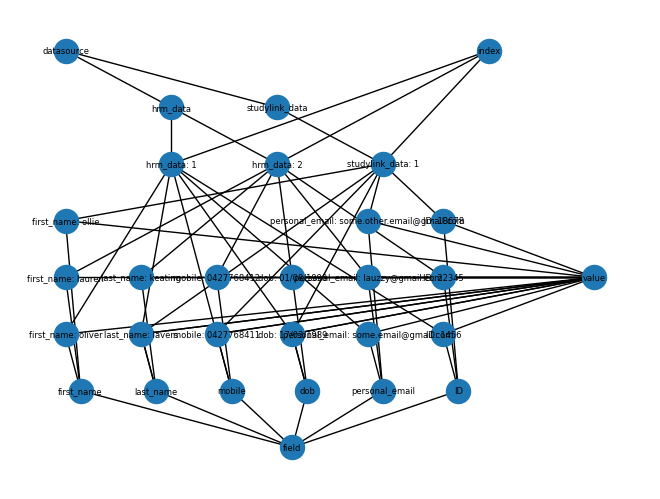

In [68]:
# We'll use a simplfied data and field set here, because the real thing is titanic and unvisualisable
datasets = {
    "hrm_data" : {
        "1": {
            "first_name": "oliver",
            "last_name": "lavers",
            "mobile": "0427768411",
            "dob": "17/03/1989",
            "personal_email": "some.email@gmail.com",
            "ID": "1456"
        },
        "2": {
            "first_name": "lauren",
            "last_name": "keating",
            "mobile": "0427768412",
            "dob": "01/08/1990",
            "personal_email": "lauzzy@gmail.com",
            "ID": "22345"
        }
    },
    "studylink_data": {
            "1": {
            "first_name": "ollie",
            "last_name": "lavers",
            "mobile": "0427768411",
            "dob": "17/03/1989",
            "personal_email": "some.other.email@gmail.com",
            "ID": "18678"
        },
    }
}

fields = [
    "first_name",
    "last_name",
    "mobile",
    "dob",
    "personal_email",
    "ID"
]

g = create_graph(datasets, fields)

positions = {
    'datasource': [0, 7], 'index': [28, 7], 'value': [35, 3], 'field': [15, 0],
    
    'first_name': [1, 1], 'last_name': [6, 1], 'mobile': [11, 1], 'dob': [16, 1], 'personal_email': [21, 1], 'ID': [26, 1], 
    
    'hrm_data': [7, 6], "studylink_data": [14, 6], 

    'hrm_data: 1': [7, 5], 'hrm_data: 2': [14, 5], 'studylink_data: 1': [21, 5],
    
    'first_name: oliver': [0, 2], 'last_name: lavers': [5, 2], 'mobile: 0427768411': [10, 2], 'dob: 17/03/1989': [15, 2], 'personal_email: some.email@gmail.com': [20, 2], 'ID: 1456': [25, 2], 
    'first_name: lauren': [0, 3], 'last_name: keating': [5, 3], 'mobile: 0427768412': [10, 3], 'dob: 01/08/1990': [15, 3], 'personal_email: lauzzy@gmail.com': [20, 3], 'ID: 22345': [25, 3], 
    'first_name: ollie': [0, 4], 'personal_email: some.other.email@gmail.com': [20, 4], 'ID: 18678': [25, 4]
}

nx.draw(g, pos=positions, with_labels=True, font_size=6)
plt.show()

Spot on! 

Next, we need to do some hardcore set work. We need to operationalise each possible ruleset. That's gonna be a headache, but we can't really do this:

```python

for node1 in g["index"]:
    for node2 in g["index"]:
        if not node1==node2:
            shared_values = set(g[node1] )&set(g[node2])
            if len(shared_values) > some_k:
                do_stuff()
```
$n*n*c*n \Longrightarrow {n^3} \approx 1 \times 10^{18}$  😳

...because it would involve around a quintillion set intersection operations, and that ain't gonna fly. Instead, we need to do something like: 

```python
for mobile_number in g["mobile"]:
    shared_mobile_indices = g[mobile_number]
    for index1 in shared_mobile_indices:
        if index1 not in {"value", "mobile"}:
            for index2 in shared_mobile_indices:
                if not index2 in {"value", "mobile"}:
                    if not index1==index2:
                        shared_values = set(g[index1])&set(g[index2])
                        if len(shared_values) > some_k:
                            do_something()
```
$n*c*c*c*c*c*c \Longrightarrow n \approx 1 000 000 $


Because that only involves around... a million set operations? Except obviously it's going to be more elegant than what I just wrote. Hopefully.

In [120]:
def pair_should_be_compared(person1, person2, sorted_index_tuple, pairs_checked):
    # can't match people with themselves, and we don't want to re-check pairings that we've looked at before
    
    if sorted_index_tuple in pairs_checked:
        return False
    if person1 == person2:
        return False
    pairs_checked.add(sorted_index_tuple) # Record that we've made the comparison now, so we don't retread this ground
    return True

def assess_match(person1, person2, sorted_index_tuple, threshold, pairs_over_threshold):
    shared_fields = g.adj[person1].keys() & g.adj[person2].keys() # Avg case: O(min(len(g.adj[person1]), len(g.adj[person2]))
    num_shared_fields = len(shared_fields)
    if num_shared_fields > threshold:  # By default each pair of people shares the field "index", so we use > here, not >=
        pairs_over_threshold[sorted_index_tuple] = num_shared_fields-1 # Gotta sort so we don't double up later! We are mutating the object passed in, here, so we don't need to return anything


def find_matches(g, field_name, field_value, threshold, pairs_over_threshold, pairs_checked): # field_value here takes the form f"{field_name}: {value}"
    """pairs_over_threshold will be mutated to add in any pairs that are detected to have at least as many fields in common as the supplied threshold indicates
    """
    
    irrelevant_nodes = {"value", field_name} # Every field value node is connected to the "value" node and it's own fieldname node, but we don't want to trace those links.
    similar_people = g.adj[field_value].keys() - irrelevant_nodes # This returns a set-like object -> a view of the keys in an adjacency view, which is a View into a dict-of-dict-of-dict data structure. 

    for person1 in similar_people:
        for person2 in similar_people:
            sorted_index_tuple = tuple(sorted([person1, person2])) # We will be using this three times so we might as well calculate it once here
            if pair_should_be_compared(person1, person2, sorted_index_tuple, pairs_checked): 
                # INSERT CODE HERE TO LOOK AT ONLY RELEVANT FIELDS
                assess_match(person1, person2, sorted_index_tuple, threshold, pairs_over_threshold)




In [121]:
pairs_over_threshold = dict()
pairs_checked = set()
for val in g.adj["mobile"].keys()-{"field"}:
    find_matches(g, "mobile", val, 3, pairs_over_threshold, pairs_checked)
print(f"result: {pairs_over_threshold}\n\n")


result: {('hrm_data: 1', 'studylink_data: 1'): 3}




In [122]:
# So then we can keep a single register of pairs that have been checked, tighten in that find_matches function so that it only notices a relevant subset of matching fields, and run through the data once for each primary match field!